In [ ]:
! pip install matplotlib
! pip install seaborn
! pip install tabulate
! pip install altair
! pip install plotly

In [1]:
import matplotlib.pyplot as plt
from data import load_data, save_to_json, load_from_json
from matplotlib.gridspec import GridSpec
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tabulate import tabulate
import pandas as pd
from itertools import zip_longest
from pandas import MultiIndex
import altair as alt
import os

from collections import defaultdict

In [2]:
from math import log
# from scipy.stats import kendalltau

COLORS = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'grey', 'pink']

def avg(l):
    return sum(l) / len(l)

def brier_score(pred):
    return avg([(x - 1) ** 2 for x in pred])

def log_loss(pred):
    return -1 * avg([log(x) for x in pred])

# def kendall_tau_for_results(model_results):
#     detection_scores = [i['detection_score'] for i in model_results] 
#     self_preferences = [i['self_preference'] for i in model_results]
    
#     return kendalltau(detection_scores, self_preferences).correlation

# def kendall_tau(x, y):
#     return kendalltau(x, y).correlation



In [3]:
# models = results_to_load = ["gpt4_results_2_ChatGPT_no_context_50_sentence.json", "gpt4_results_5_ChatGPT_no_context_50_sentence.json", 
#                             'gpt4_results_2_ChatGPT_no_context_bothsentences_50_sentence.json', 'gpt4_results_5_ChatGPT_no_context_bothsentences_50_sentence.json']
# data_path = os.path.join("results","cnn","synonym")

#models = results_to_load = ["gpt4_results_gpt4_paraphrased.json", "gpt4_results_gpt4_paraphrased_source_only.json", "gpt4_results_gpt4_paraphrased_other_only.json"]
#models = results_to_load = ["gpt4_preference_results_gpt_paraphrased_450.json","gpt4_preference_results_gpt_paraphrased_source_only_450.json","gpt4_preference_results_gpt_paraphrased_other_only_450.json" ] 
models = results_to_load = ["gpt4_preference_2_ChatGPT_with_context_bothsentences_500_sentence.json"]
#data_path = os.path.join("results","cnn")
data_path = os.path.join("results","cnn","synonym")
# xsum_responses, xsum_articles, xsum_keys = load_data('xsum')
cnn_responses, cnn_articles, cnn_keys = load_data('cnn')

# xsum_results = {}
cnn_results = {}
for model in results_to_load:
    # xsum_results[model] = load_from_json(f'results/xsum/{model}_results.json')
    cnn_results[model] = load_from_json(os.path.join(data_path, model))
    


In [ ]:
# loading old results for compairson for the selected keys
# all relevant keys
keys_list = [d['key'] for d in cnn_results['gpt4_results_gpt4_paraphrased.json']]
keys_list = set(keys_list)

# filter old results to keep only the 50 sentences
old_result = load_from_json(os.path.join("results","cnn","gpt4_results.json")) 
filtered_list = []
# Iterate over each dictionary in list_of_dicts
for d in old_result:
    # Check if any key in the current dictionary is in the keys_set
    if d['key'] in keys_list:
        filtered_list.append(d)

print(len(filtered_list))
print(len(cnn_results['gpt4_results_gpt4_paraphrased.json']))

# add to results
cnn_results['gpt4'] = filtered_list


NameError: name 'cnn_results' is not defined

In [7]:
models = models + ["gpt4"]

In [37]:
def print_zapped_table():
    table = [[model, 
                        avg([result['detection_score'] for result in cnn_results[model]]),
                        avg([0.5 if result['detection_score'] == 0.5 else 1 if result['detection_score'] > 0.5 else 0 for result in cnn_results[model]]),

    ] for model in models]

    print(tabulate(sorted(table, key = lambda x: x[-1]), headers = ['Model', 'Self-Rec (CNN)', 'Zapped' ]))
    # print(tabulate(sorted())

print_zapped_table()

Model                Self-Rec (CNN)    Zapped
-----------------  ----------------  --------
gpt4_results.json           0.74652   0.88675


In [4]:
def print_zapped_table():
    table = [[model, 
                        avg([result['self_preference'] for result in cnn_results[model]]),
                        avg([0.5 if result['self_preference'] == 0.5 else 1 if result['self_preference'] > 0.5 else 0 for result in cnn_results[model]]),

    ] for model in models]

    print(tabulate(sorted(table, key = lambda x: x[-1]), headers = ['Model', 'Self-Pref (CNN)', 'Zapped' ]))
    # print(tabulate(sorted())

print_zapped_table()

Model                                                                     Self-Pref (CNN)    Zapped
----------------------------------------------------------------------  -----------------  --------
gpt4_preference_2_ChatGPT_with_context_bothsentences_500_sentence.json           0.487059     0.487


In [7]:
# Main pairwise results
table = [[model, 
                    avg([result['detection_score'] for result in cnn_results[model]])
] for model in models]

table = [[row[0]] + [round(i, 3) for i in row[1:]] for row in table]
print(tabulate(table, headers = ['Model', 'Self-Rec']))

Model                                             Self-Rec
----------------------------------------------  ----------
gpt4_results_gpt4_paraphrased.json                   0.726
gpt4_results_gpt4_paraphrased_source_only.json       0.659
gpt4_results_gpt4_paraphrased_other_only.json        0.784
gpt4                                                 0.743


In [10]:
results = cnn_results
print(tabulate(sorted([[model, avg([result['detection_score'] for result in results[model]])]])))

----------------------------------------------------------------  --------
gpt4_results_5_ChatGPT_no_context_bothsentences_50_sentence.json  0.713225
----------------------------------------------------------------  --------


# Plots of replacement and self-recognition

## Absolute Value plots

In [10]:
file_name = "cnn_gpt4_modified_percentage.json"
path = os.path.join("summaries","cnn",file_name)
modified_percentages = load_from_json(path)

In [52]:
# Dictionary to store the sum and count of scores for each key
score_summary = defaultdict(lambda: {'detection_score': 0, 'count': 0})

# Iterate over the list and summarize scores
for record in cnn_results['gpt4_results_gpt4_paraphrased.json']:
    key = record['key']
    score_summary[key]['detection_score'] += record['detection_score']
    score_summary[key]['count'] += 1

# Calculate the average and create a summarized list
summarized_data_gpt4_results_gpt4_paraphrased = [
    {'key': key, 'detection_score': score_info['detection_score'] / score_info['count']}
    for key, score_info in score_summary.items()
]

#REPEAT

score_summary = defaultdict(lambda: {'detection_score': 0, 'count': 0})
# Iterate over the list and summarize scores
for record in cnn_results['gpt4_results_gpt4_paraphrased_source_only.json']:
    key = record['key']
    score_summary[key]['detection_score'] += record['detection_score']
    score_summary[key]['count'] += 1

# Calculate the average and create a summarized list
summarized_data_gpt4_results_gpt4_paraphrased_source_only = [
    {'key': key, 'detection_score': score_info['detection_score'] / score_info['count']}
    for key, score_info in score_summary.items()
]

#REPEAT
score_summary = defaultdict(lambda: {'detection_score': 0, 'count': 0})
# Iterate over the list and summarize scores
for record in cnn_results['gpt4_results_gpt4_paraphrased_other_only.json']:
    key = record['key']
    score_summary[key]['detection_score'] += record['detection_score']
    score_summary[key]['count'] += 1

# Calculate the average and create a summarized list
summarized_data_gpt4_results_gpt4_paraphrased_other_only = [
    {'key': key, 'detection_score': score_info['detection_score'] / score_info['count']}
    for key, score_info in score_summary.items()
]

#REPEAT for base results

score_summary = defaultdict(lambda: {'detection_score': 0, 'count': 0})
# Iterate over the list and summarize scores
for record in cnn_results['gpt4']:
    key = record['key']
    score_summary[key]['detection_score'] += record['detection_score']
    score_summary[key]['count'] += 1

# Calculate the average and create a summarized list
summarized_data_gpt4_base = [
    {'key': key, 'detection_score': score_info['detection_score'] / score_info['count']}
    for key, score_info in score_summary.items()
]
    

### Plot when both summaries are paraphrased (percentage-change)

In [24]:
paraphrase_summary = defaultdict(lambda: {'paraphrase': 0, 'count': 0})

for record in modified_percentages:
    key = record['key']
    paraphrase_summary[key]['paraphrase'] += record['paraphrase']
    paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_both = [
    {'key': key, 'paraphrase': score_info['paraphrase'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]

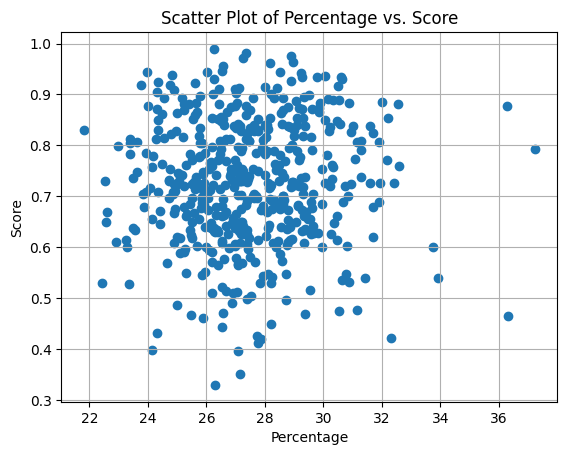

In [27]:
# Convert lists to dictionaries for easy lookup by key
percentage_dict = {item['key']: item['paraphrase'] for item in percentage_modified_both}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [score_dict[key] for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Percentage')
plt.ylabel('Score')
plt.title('Scatter Plot of Percentage vs. Score')
plt.grid(True)
plt.show()


### Plot when 'other' summary is paraphrased (percentage-change)

In [71]:
paraphrase_summary = defaultdict(lambda: {'paraphrase': 0, 'count': 0})

for record in modified_percentages:
    key = record['key']
    if record['model'] != 'gpt4':
        paraphrase_summary[key]['paraphrase'] += record['paraphrase']
        paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_other = [
    {'key': key, 'paraphrase': score_info['paraphrase'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]

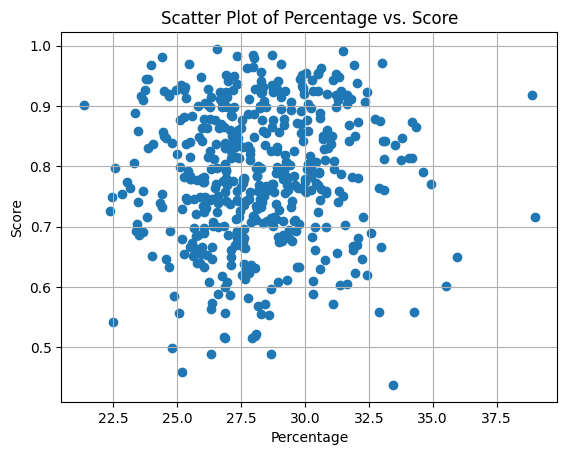

In [45]:
percentage_dict = {item['key']: item['paraphrase'] for item in percentage_modified_other}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased_other_only}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [score_dict[key] for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Percentage')
plt.ylabel('Score')
plt.title('Scatter Plot of Percentage vs. Score')
plt.grid(True)
plt.show()


### Plot when gpt4 summary is paraphrased (percentage-change)

In [75]:
paraphrase_summary = defaultdict(lambda: {'paraphrase': 0, 'count': 0})

for record in modified_percentages:
    key = record['key']
    if record['model'] == 'gpt4':
        paraphrase_summary[key]['paraphrase'] += record['paraphrase']
        paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_gpt4 = [
    {'key': key, 'paraphrase': score_info['paraphrase'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]

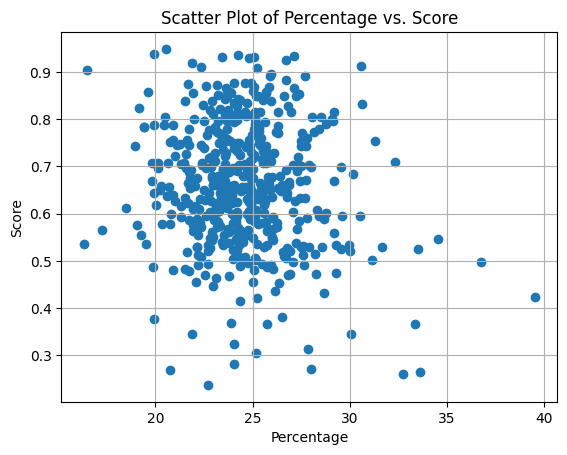

In [31]:
percentage_dict = {item['key']: item['paraphrase'] for item in percentage_modified_gpt4}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased_source_only}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [score_dict[key] for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Percentage')
plt.ylabel('Score')
plt.title('Scatter Plot of Percentage vs. Score')
plt.grid(True)
plt.show()


### Plot when both summaries are paraphrased (length-change)

In [62]:
file_name = "cnn_gpt4_modified_length.json"
path = os.path.join("summaries","cnn",file_name)
length_modified = load_from_json(path)

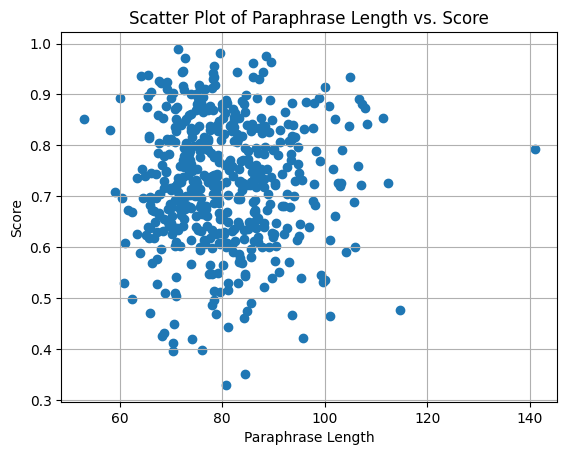

In [46]:
paraphrase_summary = defaultdict(lambda: {'paraphrase_length': 0, 'count': 0})

for record in length_modified:
    key = record['key']
    paraphrase_summary[key]['paraphrase_length'] += record['paraphrase_length']
    paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_both = [
    {'key': key, 'paraphrase_length': score_info['paraphrase_length'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]


# Convert lists to dictionaries for easy lookup by key
percentage_dict = {item['key']: item['paraphrase_length'] for item in percentage_modified_both}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [score_dict[key] for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Paraphrase Length')
plt.ylabel('Score')
plt.title('Scatter Plot of Paraphrase Length vs. Score')
plt.grid(True)
plt.show()


### Plot when 'other' summary is paraphrased (length-change)

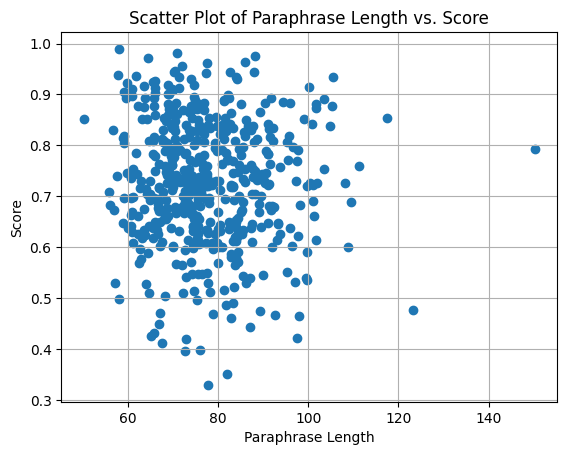

In [47]:
paraphrase_summary = defaultdict(lambda: {'paraphrase_length': 0, 'count': 0})

for record in length_modified:
    key = record['key']
    if record['model'] != 'gpt4':
        paraphrase_summary[key]['paraphrase_length'] += record['paraphrase_length']
        paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_other = [
    {'key': key, 'paraphrase_length': score_info['paraphrase_length'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]


# Convert lists to dictionaries for easy lookup by key
percentage_dict = {item['key']: item['paraphrase_length'] for item in percentage_modified_other}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [score_dict[key] for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Paraphrase Length')
plt.ylabel('Score')
plt.title('Scatter Plot of Paraphrase Length vs. Score')
plt.grid(True)
plt.show()


### Plot when gpt4 summary is paraphrased (length-change)

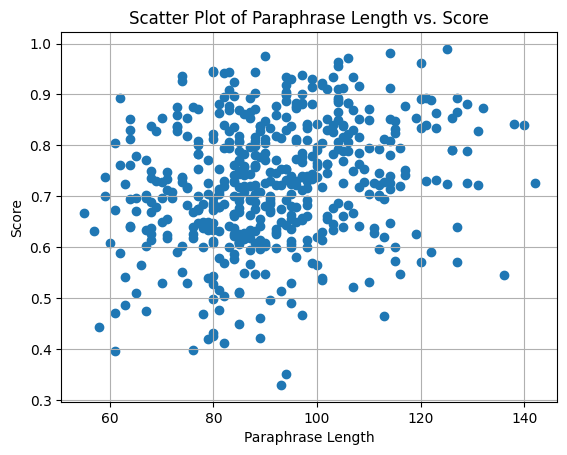

In [48]:
paraphrase_summary = defaultdict(lambda: {'paraphrase_length': 0, 'count': 0})

for record in length_modified:
    key = record['key']
    if record['model'] == 'gpt4':
        paraphrase_summary[key]['paraphrase_length'] += record['paraphrase_length']
        paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_self = [
    {'key': key, 'paraphrase_length': score_info['paraphrase_length'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]


# Convert lists to dictionaries for easy lookup by key
percentage_dict = {item['key']: item['paraphrase_length'] for item in percentage_modified_self}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [score_dict[key] for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Paraphrase Length')
plt.ylabel('Score')
plt.title('Scatter Plot of Paraphrase Length vs. Score')
plt.grid(True)
plt.show()


## Delta Plots

In [68]:
paraphrase_summary = defaultdict(lambda: {'paraphrase': 0, 'count': 0})

for record in modified_percentages:
    key = record['key']
    paraphrase_summary[key]['paraphrase'] += record['paraphrase']
    paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_both = [
    {'key': key, 'paraphrase': score_info['paraphrase'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]

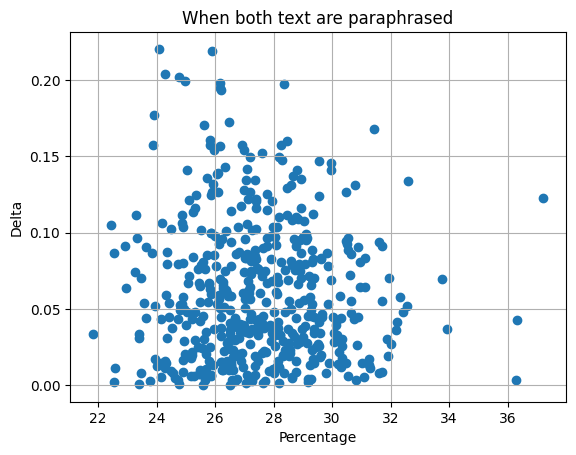

In [69]:
# Convert lists to dictionaries for easy lookup by key
percentage_dict = {item['key']: item['paraphrase'] for item in percentage_modified_both}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased}
score_dict_base = {item['key']: item['detection_score'] for item in summarized_data_gpt4_base}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [abs(score_dict[key]- score_dict_base[key]) for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Percentage')
plt.ylabel('Delta')
plt.title('When both text are paraphrased')
plt.grid(True)
plt.show()


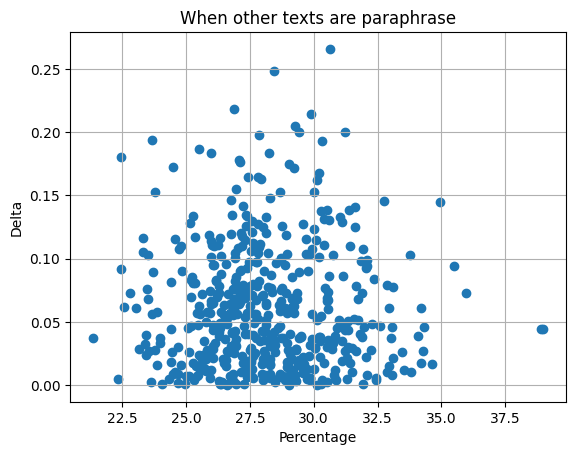

In [77]:
percentage_dict = {item['key']: item['paraphrase'] for item in percentage_modified_other}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased_other_only}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [abs(score_dict[key]- score_dict_base[key]) for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Percentage')
plt.ylabel('Delta')
plt.title('When other texts are paraphrase')
plt.grid(True)
plt.show()


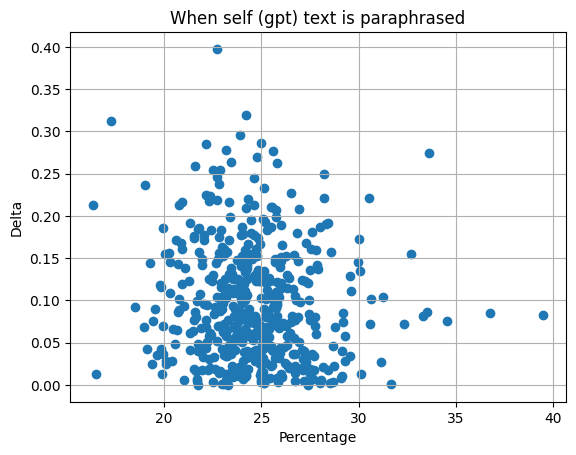

In [78]:
percentage_dict = {item['key']: item['paraphrase'] for item in percentage_modified_gpt4}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased_source_only}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [abs(score_dict[key]- score_dict_base[key]) for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Percentage')
plt.ylabel('Delta')
plt.title('When self (gpt) text is paraphrased')
plt.grid(True)
plt.show()


### Length Wise

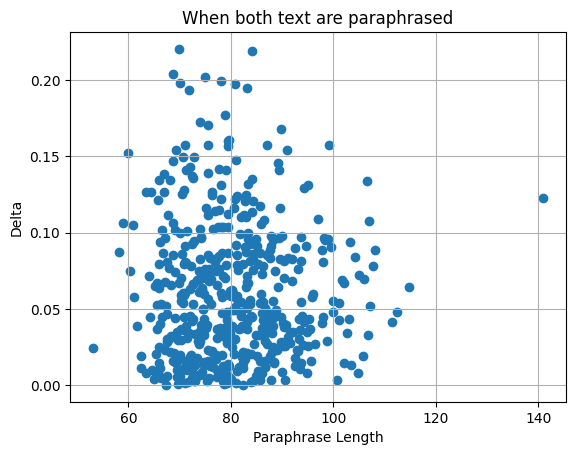

In [79]:
paraphrase_summary = defaultdict(lambda: {'paraphrase_length': 0, 'count': 0})

for record in length_modified:
    key = record['key']
    paraphrase_summary[key]['paraphrase_length'] += record['paraphrase_length']
    paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_both = [
    {'key': key, 'paraphrase_length': score_info['paraphrase_length'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]


# Convert lists to dictionaries for easy lookup by key
percentage_dict = {item['key']: item['paraphrase_length'] for item in percentage_modified_both}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [abs(score_dict[key]- score_dict_base[key]) for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Paraphrase Length')
plt.ylabel('Delta')
plt.title('When both text are paraphrased')
plt.grid(True)
plt.show()


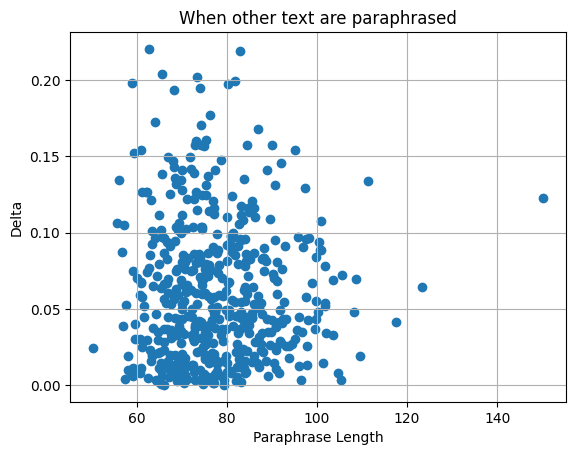

In [80]:
paraphrase_summary = defaultdict(lambda: {'paraphrase_length': 0, 'count': 0})

for record in length_modified:
    key = record['key']
    if record['model'] != 'gpt4':
        paraphrase_summary[key]['paraphrase_length'] += record['paraphrase_length']
        paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_other = [
    {'key': key, 'paraphrase_length': score_info['paraphrase_length'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]


# Convert lists to dictionaries for easy lookup by key
percentage_dict = {item['key']: item['paraphrase_length'] for item in percentage_modified_other}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [abs(score_dict[key]- score_dict_base[key]) for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Paraphrase Length')
plt.ylabel('Delta')
plt.title('When other text are paraphrased')
plt.grid(True)
plt.show()


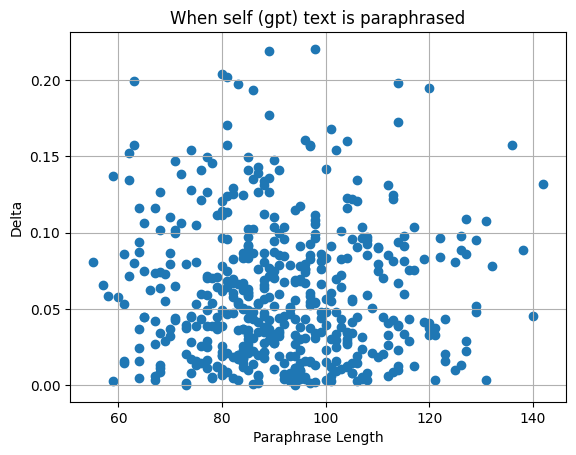

In [81]:
paraphrase_summary = defaultdict(lambda: {'paraphrase_length': 0, 'count': 0})

for record in length_modified:
    key = record['key']
    if record['model'] == 'gpt4':
        paraphrase_summary[key]['paraphrase_length'] += record['paraphrase_length']
        paraphrase_summary[key]['count'] += 1

# Calculate the average and create a summarized list
percentage_modified_self = [
    {'key': key, 'paraphrase_length': score_info['paraphrase_length'] / score_info['count']}
    for key, score_info in paraphrase_summary.items()
]


# Convert lists to dictionaries for easy lookup by key
percentage_dict = {item['key']: item['paraphrase_length'] for item in percentage_modified_self}
score_dict = {item['key']: item['detection_score'] for item in summarized_data_gpt4_results_gpt4_paraphrased}

# Extract common keys, and create lists for percentage and score values
common_keys = set(percentage_dict.keys()) & set(score_dict.keys())
percentages = [percentage_dict[key] for key in common_keys]
scores = [abs(score_dict[key]- score_dict_base[key]) for key in common_keys]

# Plot the scatter plot
plt.scatter(percentages, scores)
plt.xlabel('Paraphrase Length')
plt.ylabel('Delta')
plt.title('When self (gpt) text is paraphrased')
plt.grid(True)
plt.show()


# Looking at what's replaced

In [8]:
from tqdm import tqdm
import time
import random
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
import difflib
import pandas as pd

In [7]:


# Set the seed for reproducibility
random.seed(123)

all_words = []
all_syn = []

def get_synonyms(word):
    """
    Finds and returns synonyms for a given word using WordNet.
    This function takes a word as input, searches for its synonyms 
    using the WordNet synsets, and returns a list of synonyms.

    Args:
        word (str): The word for which to find synonyms.
    Returns:
        list: A list of synonyms for the input word. Returns an 
              empty list if no synonyms are found.
    """
    synonyms = []
    for syn in wordnet.synsets(word):
        for name in syn.lemma_names():
            # Exclude the original word to avoid replacing it with itself
            name = name.replace('_',' ')
            if name.lower() != word.lower():
                synonyms.append(name)
    return synonyms

def replace_with_synonyms(sentence, num_words_to_replace):
    """
    Replaces a specified number of words in a sentence with their synonyms.

    This function takes a sentence and an integer specifying the number of words 
    to replace with synonyms. It randomly samples 2x the required number of words 
    to ensure replacements are possible even if some words do not have synonyms.
    It uses the `get_synonyms` function to find synonyms for each sampled word,
    and replaces words in the sentence until the specified number is reached.

    Args:
        sentence (str): The input sentence from which words will be replaced.
        num_words_to_replace (int): The number of words in the sentence to be replaced by synonyms.

    Returns:
        str: The modified sentence with the specified number of words replaced by synonyms.
    """
    # Tokenize the sentence
    words = word_tokenize(sentence)
    # Filter out non-alphabetic tokens (like punctuation)
    words_alpha = [word for word in words if word.isalpha()]
    
    # Randomly sample words to replace - i use 2x words just to account for words without synonym
    words_to_replace = random.sample(words_alpha, min(2*num_words_to_replace, len(words_alpha)))
    
    # Create a new sentence with synonyms replaced
    words_replaced = 0
    new_sentence = []
    for word in words:
        if word in words_to_replace:
            synonyms = get_synonyms(word)
            if synonyms and words_replaced < num_words_to_replace:
                # Replace with a random synonym
                new_word = random.choice(synonyms)
                new_sentence.append(new_word)
                #operational
                all_words.append(word)
                all_syn.append(synonyms)
                words_replaced +=1
            else:
                # If no synonym is found, keep the original word
                new_sentence.append(word)
        else:
            new_sentence.append(word)
    
    return ' '.join(new_sentence)



In [9]:
# Only suitable for GPT models
def explore_synonym(
    dataset,
    model,
    starting_idx=0,
    detection_type="detection",
    replace_synonym = False,
    num_words_to_replace = 0
):

    # For retrieving summaries, the specific fine-tuning version isn't needed
    exact_model = model
    model = "gpt35" if model.endswith("gpt35") else model

    responses, articles, keys = load_data(dataset)
    all_original = []
    all_modified = []

    for key in tqdm(keys[starting_idx:], desc="Processing keys"):
        article = articles[key]

        source_summary = responses[model][key]
        all_original.append(source_summary)
        # replace synonym
        if replace_synonym:
            source_summary = replace_with_synonyms(source_summary, num_words_to_replace)
            all_modified.append(source_summary)



    return all_original, all_modified


In [10]:
num_synonym = 2
all_original, all_modified = explore_synonym(
    "cnn", "gpt4",replace_synonym=True, num_words_to_replace=num_synonym, starting_idx=950
)


Processing keys: 100%|██████████| 50/50 [00:01<00:00, 26.89it/s]


In [23]:
# Function to remove space before commas
def remove_space_before_comma(sentences):
    return [sentence.replace(" ,", ",") for sentence in sentences]

# Cleaned sentences
all_modified = remove_space_before_comma(all_modified)

In [24]:
def find_difference_context(sentence1, sentence2):
    # Tokenize the sentences into words
    words1 = sentence1.split()
    words2 = sentence2.split()

    # Use difflib to find matching blocks and differences
    matcher = difflib.SequenceMatcher(None, words1, words2)
    diffs = []
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag != 'equal':  # Capture the differing segments
            # Extract two words before and after the difference (if they exist)
            context1 = ' '.join(words1[max(0, i1-2):i2+2])
            context2 = ' '.join(words2[max(0, j1-2):j2+2])
            diffs.append((context1, context2))
    
    return diffs

def generate_report(list1, list2):
    data = {'Sentence1': [], 'Sentence2': [], 'Difference Context 1': [], 'Difference Context 2': []}

    # Ensure both lists are of the same length
    for sentence1, sentence2 in zip(list1, list2):
        differences = find_difference_context(sentence1, sentence2)
        
        if differences:
            for diff1, diff2 in differences:
                data['Sentence1'].append(sentence1)
                data['Sentence2'].append(sentence2)
                data['Difference Context 1'].append(diff1)
                data['Difference Context 2'].append(diff2)
        else:
            data['Sentence1'].append(sentence1)
            data['Sentence2'].append(sentence2)
            data['Difference Context 1'].append("No differences")
            data['Difference Context 2'].append("No differences")
    
    # Create a pandas DataFrame
    df = pd.DataFrame(data)
    
    return df



In [26]:
# Generate the report
report = generate_report(all_original, all_modified)

# Print the DataFrame or save it as a report
print(report.head())

report.to_csv('sentence_comparison_report.csv', index=False)

                                           Sentence1  \
0  Hurricane Ike devastates Texas, leaving reside...   
1  Hurricane Ike devastates Texas, leaving reside...   
2  Susana Trimarco's daughter, Marita Veron, vani...   
3  Susana Trimarco's daughter, Marita Veron, vani...   
4  Susana Trimarco's daughter, Marita Veron, vani...   

                                           Sentence2  \
0  Hurricane Ike devastates TX, leaving occupier ...   
1  Hurricane Ike devastates TX, leaving occupier ...   
2  Susana Trimarco 's daughter, Marita Veron, van...   
3  Susana Trimarco 's daughter, Marita Veron, van...   
4  Susana Trimarco 's daughter, Marita Veron, van...   

                                Difference Context 1  \
0            Ike devastates Texas, leaving residents   
1           Texas, leaving residents struggling with   
2                 Susana Trimarco's daughter, Marita   
3                    forced into a human trafficking   
4  soap opera "Vidas Robadas," highlighting th